In [1]:
%matplotlib widget
import raster_geometry as rg
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# size = (100, 100, 100)
radius = 5
size = 2 * (radius + 1)
# position = (50, 50, 50)

midpoint = [size / 2] * 3
print(midpoint)

# target = rg.nd_superellipsoid(size, radius, position=position, rel_sizes=False, rel_position=False)
print(f"Radius: {radius}, Container size: {size}")
sphere = rg.nd_superellipsoid(size, radius, position=midpoint, rel_sizes=False, rel_position=False).astype(np.int_)
# sphere = rg.sphere(size, radius, 0.5).astype(np.int_)

[6.0, 6.0, 6.0]
Radius: 5, Container size: 12


In [3]:
sphere.shape

(12, 12, 12)

In [4]:
def draw_sphere_in_volume(volume: np.ndarray, radius: int, position: tuple) -> None:
    """
    Draw a sphere in a given 3D NumPy array at a specified position.

    Args:
    volume (numpy.ndarray): The 3D NumPy array in which the sphere will be drawn.
    radius (int): The radius of the sphere.
    position (tuple): A 3-tuple containing the z, x, y coordinates of the position in the array where the sphere will be drawn.

    Returns:
    None
    """
    # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
    size = 2 * (radius + 1)


    # Calculate the midpoint of the array
    midpoint = [size / 2] * 3

    # Generate the sphere using the rg library's superellipsoid function
    sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
                                  rel_sizes=False, rel_position=False).astype(np.int_)

    # Extract the z, x, and y coordinates of the position where the sphere will be drawn
    z, x, y = position

    # Calculate the delta change needed to center the sphere at the specified position
    d = (size//2)

    zmin, zmax = max(z - d, 0), min(z + d, volume.shape[0])
    xmin, xmax = max(x - d, 0), min(x + d, volume.shape[1])
    ymin, ymax = max(y - d, 0), min(y + d, volume.shape[2])

    szmin = abs(z - d) if z - d < 0 else 0
    sxmin = abs(x - d) if x - d < 0 else 0
    symin = abs(y - d) if y - d < 0 else 0
    szmax = abs(volume.shape[0] - (z + d)) if z + d > volume.shape[0] else 0
    sxmax = abs(volume.shape[1] - (x + d)) if x + d > volume.shape[1] else 0
    symax = abs(volume.shape[2] - (y + d)) if y + d > volume.shape[2] else 0
    print(z - d, z + d, zmax-zmin, szmin, szmax)
    print(x - d, x + d, xmax-xmin, sxmin, sxmax)
    print(y - d, y + d, ymax-ymin, symin, symax)

    sphere = sphere[szmin:sphere.shape[0]-szmax, sxmin:sphere.shape[1]-sxmax, symin:sphere.shape[2]-symax]

    # Place the sphere within the larger volume array at the specified position
    volume[zmin:zmax, xmin:xmax, ymin:ymax] = sphere

In [5]:
volume = np.zeros((10,10,10))

draw_sphere_in_volume(volume, 8, (0,0,0))

-9 9 9 9 0
-9 9 9 9 0
-9 9 9 9 0


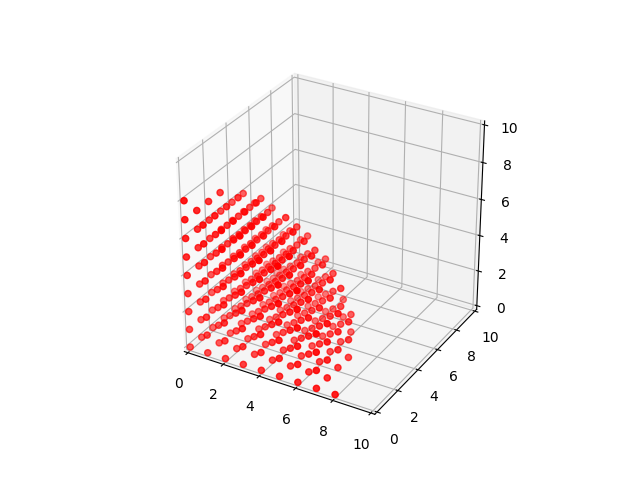

In [6]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

z,x,y = volume.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
set_aspect_ratio_equal(ax)
ax.axes.set_xlim3d(left=0, right=volume.shape[0]) 
ax.axes.set_ylim3d(bottom=0, top=volume.shape[1]) 
ax.axes.set_zlim3d(bottom=0, top=volume.shape[2]) 
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.show()